In [1]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Markdown, display
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import sys
import dataset

# sys.path.append("src/")

device = torch.device("cuda" if torch.cuda.is_available()
                else "mps" if torch.backends.mps.is_built() else "cpu")
print(f"Device: {device}")

# print(torch.cuda.get_device_name(0))
# sns.set()

Device: cuda


### Visualization functions

In [2]:
import matplotlib.pyplot as plt

def plot_both(image1,image2):
    plt.figure(figsize=(10, 5))

    # Plot first image
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.title('Image 1')

    # Plot second image
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Image 2')

    plt.show()


def compose_output(original_image, recreated_image):
    print(original_image.shape)
    print(recreated_image.shape)
    l = original_image[0,:,:]
    print("L shape",l.shape)
    return torch.cat((l.unsqueeze(0),recreated_image),0)

'''
TODO: when using lab color space we have certain artefacts that do not appear when we only use RGB images

may be from normalization in the lab space or the transformation itself

entry[image][0]
'''
def visualize(entry,model,lab=False):
    image = entry['grayscale_image']
    output = model(image.unsqueeze(0).to(device))
    output = output.detach().cpu().squeeze(0)

    if lab:
        lab2rgb = dataset.LABtoRGB()
        rgb_image = lab2rgb(entry['image'])
        ## TODO: if here entry['image'][0:1,:,:] is used, the image is not displayed correctly
        composed_lab = torch.cat((entry['grayscale_image'],output),0)
        composed_output = lab2rgb(composed_lab)


    plot_both(rgb_image.permute(1,2,0).numpy(),composed_output.permute(1,2,0).numpy())


In [3]:

def plot_grid(images_column1, images_column2):
    '''
    Plots a 2x8 grid of rgb images, where each row corresponds to a pair of images from the two input lists.
    '''
    num_images_column1 = len(images_column1)
    num_images_column2 = len(images_column2)
    num_rows = max(num_images_column1, num_images_column2)
    
    plt.figure(figsize=(12, 8))  # Adjust figsize as needed

    for i in range(num_rows):
        # Plot images from the first column
        if i < num_images_column1:
            plt.subplot(num_rows, 2, 2*i + 1)
            plt.imshow(images_column1[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 1)')
            plt.axis('off')  # Turn off axis for better visualization
        
        # Plot images from the second column
        if i < num_images_column2:
            plt.subplot(num_rows, 2, 2*i + 2)
            plt.imshow(images_column2[i].permute(1,2,0).numpy())
            # plt.title(f'Image {i + 1} (Column 2)')
            plt.axis('off')  # Turn off axis for better visualization

    plt.tight_layout(pad=0.1)  # Adjust spacing between subplots
    plt.show()

def get_visualization_images(indexes):
    data = list(train_data)
    tbr = []
    for idx in indexes:
        tbr.append(data[idx]['image'])

    return tbr

def get_batch_outputs(images):
    ## batch the images
    images = torch.stack(images)
    output = net(images.to(device))
    return [output[i].detach().cpu() for i in range(output.shape[0])]

### Architecture

In [4]:

class Adain_Encoder(nn.Module):
    def __init__(self, in_channels, out_dim):
        super(Adain_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(512, out_dim, kernel_size=3, stride=2, padding=1)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = torch.relu(self.conv5(x))
        
        # Global average pooling
        x = self.global_avg_pool(x)        
        # Flatten
        x = x.view(x.size(0), -1)
        
        return x

# Example usage:
# Define input and output dimensions
in_channels = 3  # number of input channels
out_dim = 128  # size of the output representation

# Create an instance of the ConvNet
model = Adain_Encoder(in_channels, out_dim)

# Create a random input tensor
input_tensor = torch.randn(4, in_channels, 256, 256)

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 128])


In [5]:
import torch.nn.init as init

class AdaIN(nn.Module):
    
    def __init__(self, style_dim, channels):
        super(AdaIN, self).__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale_transform = nn.Linear(style_dim, channels)
        self.style_shift_transform = nn.Linear(style_dim, channels)

        ## to ensure they learn different stuff | How tho?
        init.normal_(self.style_scale_transform.weight, mean=1.0, std=0.02)
        init.normal_(self.style_shift_transform.weight, mean=0.0, std=0.02)

        self.style_scale_transform.bias.data.fill_(1)  # Initialize scale to 1
        self.style_shift_transform.bias.data.fill_(0)  # Initialize shift to 0

    def forward(self, x, style):
        '''
        x - feature maps from the unet
        y - learned (jointly) from encoder

        return:
        same size as x
        '''
        # Normalize the input feature map
        normalized = self.instance_norm(x)
        
        # Extract style scale and shift parameters from the style vector
        scale = self.style_scale_transform(style)[:, :, None, None]
        shift = self.style_shift_transform(style)[:, :, None, None]

        # print(scale.squeeze()[:10])
        # print(shift.squeeze()[:10])
        
        # Apply scale and shift to the normalized feature map
        transformed = scale * normalized + shift
        
        return transformed

# Example usage:
# Define the dimensions
style_dim = 128  # dimensionality of the style vector
channels = 256    # number of channels in the feature map

# Create an instance of AdaIN
adain = AdaIN(style_dim, channels)

# Generate random input feature map and style vector
x = torch.randn(4, channels, 64, 64)  # Example input feature map
style = torch.randn(1, style_dim)     # Example style vector

# Apply AdaIN

output = adain(x, style)

print("Output shape:", output.shape)


Output shape: torch.Size([4, 256, 64, 64])


In [21]:
class UNet(nn.Module):
    def __init__(self, in_C = 3, out_C=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_C, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.maxpool_1to2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.maxpool_2to3 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.maxpool_3to4 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )
        self.maxpool_4to5 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
        )

        # Decoder
        self.conv_transpose_5to6 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.conv1d_fusing_5to6 = nn.Conv2d(1024, 512, 1)
        self.conv6 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )
        self.conv_transpose_6to7 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1)
        self.conv1d_fusing_6to7 = nn.Conv2d(512, 256, 1)
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.conv_transpose_7to8 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.conv1d_fusing_7to8 = nn.Conv2d(256, 128, 1)
        self.conv8 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv_transpose8to9 = nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1)
        self.conv1d_fusing_8to9 = nn.Conv2d(128, 64, 1)
        self.conv9 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),      # Simmetry broken here: keeps being 64 (from paper)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv10 = nn.Conv2d(64, out_C, 1)

        '''
        Conv1 shape torch.Size([16, 64, 128, 128])
        Conv2 shape torch.Size([16, 128, 64, 64])
        Conv3 shape torch.Size([16, 256, 32, 32])
        Conv4 shape torch.Size([16, 512, 16, 16])
        Conv5 shape torch.Size([16, 512, 8, 8])
        '''

        ## we need adain layers defined for each number of channels of the feature maps
        ## NOTE: adain2 learns a non linear mapping in the same dimensional space, does it matter?
        self.encoder_adain1 = AdaIN(128, 64)
        self.encoder_adain2 = AdaIN(128, 128)
        self.encoder_adain3 = AdaIN(128, 256)
        self.encoder_adain4 = AdaIN(128, 512)
        self.encoder_adain5 = AdaIN(128, 512)

        self.decoder_adain4 = AdaIN(128, 512)
        self.decoder_adain3 = AdaIN(128, 256)
        self.decoder_adain2 = AdaIN(128, 128)
        self.decoder_adain1 = AdaIN(128, 64)


    def forward(self,x,style):
        x=x.to(device)
        style = style.to(device)

        # Encoder
        conv1 = self.conv1(x)
        conv1 = self.encoder_adain1(x,style) ## AdaIN

        maxpooled_1to2 = self.maxpool_1to2(conv1)
        conv2 = self.conv2(maxpooled_1to2)
        conv2 = self.encoder_adain2(conv2,style) ## AdaIN

        maxpooled_2to3 = self.maxpool_2to3(conv2)
        conv3 = self.conv3(maxpooled_2to3)
        conv3 = self.encoder_adain3(conv3,style) ## AdaIN

        maxpooled_3to4 = self.maxpool_3to4(conv3)
        conv4 = self.conv4(maxpooled_3to4)
        conv4 = self.encoder_adain4(conv4,style) ## AdaIN

        maxpooled_4to5 = self.maxpool_4to5(conv4)
        conv5 = self.conv5(maxpooled_4to5)
        conv5 = self.encoder_adain5(conv5,style) ## AdaIN
        # Decoder
        # concatenation_5to6 = torch.cat((conv4,self.decoder_adain4(self.conv_transpose_5to6(conv5),style)),1)
        concatenation_5to6 = torch.cat((conv4,self.conv_transpose_5to6(conv5)),1)
        skip_fusion_5to6 = self.conv1d_fusing_5to6(concatenation_5to6)
        conv6 = self.conv6(skip_fusion_5to6)

        # concatenation_6to7 = torch.cat((conv3, self.decoder_adain3(self.conv_transpose_6to7(conv6),style)),1)
        concatenation_6to7 = torch.cat((conv3, self.conv_transpose_6to7(conv6)),1)
        skip_fusion_6to7 = self.conv1d_fusing_6to7(concatenation_6to7)
        conv7 = self.conv7(skip_fusion_6to7)

        # concatenation_7to8 = torch.cat((conv2, self.decoder_adain2(self.conv_transpose_7to8(conv7),style)),1)
        concatenation_7to8 = torch.cat((conv2, self.conv_transpose_7to8(conv7)),1)
        skip_fusion_7to8 = self.conv1d_fusing_7to8(concatenation_7to8)
        conv8 = self.conv8(skip_fusion_7to8)

        # concatenation_8_to9 = torch.cat((conv1, self.decoder_adain1(self.conv_transpose8to9(conv8),style)),1)
        concatenation_8_to9 = torch.cat((conv1, self.conv_transpose8to9(conv8)),1)
        skip_fusion_8to9 = self.conv1d_fusing_8to9(concatenation_8_to9)
        conv9 = self.conv9(skip_fusion_8to9)

        output = self.conv10(conv9)
        return output

    def train_model(self, train_loader, val_loader, 
                    epochs=10, 
                    lr=0.001, 
                    loss_fn=nn.MSELoss(), 
                    optimizer=torch.optim.Adam, 
                    verbose=True, 
                    save_path = "./model_storage/", 
                    save_name_prefix='/',
                    colorspace='RGB'):

        '''
        save_path = folder for saving results
        save_name_prefix = prefix for saved files to mark experiments (start with '/')


        '''


        loss_df = pd.DataFrame(['training_loss', 'validation_loss'])
        self.to(device)
        self.train()
        optimizer = optimizer(self.parameters(), lr=lr)

        #for saving progress
        best_val_loss = 99999
        val_loss_list = []
        training_loss_list = []

        for epoch in tqdm(range(epochs)):
            training_loss = 0
            for i, batch_data in enumerate(train_loader):
                image = batch_data['grayscale_image']
                image = image.to(device)
                optimizer.zero_grad()
                reproduced_image = self(image)
                reproduced_image = reproduced_image.to(device)
                ## aici trebuie comparat doar cu canalele ab
                if colorspace == 'RGB':
                    loss = loss_fn(reproduced_image, batch_data['image'].to(device))
                elif colorspace == 'LAB':
                    loss = loss_fn(reproduced_image, batch_data['image'][:,1:,:,:].to(device))
                training_loss += loss.item()
                loss.backward()
                optimizer.step()

            #average training loss
            training_loss /= len(train_loader)
            training_loss_list.append(training_loss)


            if (epoch)%5 == 0 or (epoch + 1) == epochs:
                val_loss = 0.0  # Track validation loss
                with torch.no_grad():  # Disable gradient calculation for validation
                    for val_data in val_loader:
                        val_image = val_data['grayscale_image']
                        val_image = val_image.to(device)

                        val_reproduced_image = self(val_image)
                        val_reproduced_image = val_reproduced_image.to(device)
                        if colorspace == 'RGB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'].to(device)).item()
                        elif colorspace == 'LAB':
                            val_loss += loss_fn(val_reproduced_image, val_data['image'][:,1:,:,:].to(device)).item()
                       
                val_loss /= len(val_loader)  # Calculate average validation loss
                val_loss_list.append(val_loss)

                if verbose:
                  print(f"Epoch {epoch}, training_loss = {training_loss}")
                  print(f"Epoch {epoch}: validation loss = {val_loss}")


                if val_loss < best_val_loss:  # Update best validation loss and save checkpoint if best model
                  state_diction = self.state_dict()
                  best_val_loss = val_loss
                  for key in state_diction.keys():
                      state_diction[key] = state_diction[key].to(torch.device('cpu'))
                  torch.save(state_diction, (save_path+save_name_prefix+f"UNet_best_model.pth.tar"))

                #construct df with losses
                loss_df = pd.DataFrame({'epoch': range(0,epoch+1),  'training_loss':training_loss_list, 'val_loss': val_loss_list})
                loss_df.to_csv(save_path+save_name_prefix+"UNet_loss.csv", index=False)
                # plot losses
                plt.plot(loss_df['epoch'], loss_df['training_loss'], label='Training Loss')
                plt.plot(loss_df['epoch'], loss_df['val_loss'].interpolate(method='linear'), label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss')
                plt.legend()

                # Save plot as .png file
                plt.savefig(save_path+save_name_prefix+'UNet_loss_plot.png')
                plt.clf()
            else:
              val_loss_list.append(np.nan)


### Colorization from RGB color space. 

Input is a HxW grayscale image.
Output is a 3xHxW RGB image.

No std and mean normalization is used.

In [35]:
TRAIN_SIZE = 400
VAL_SIZE = 100
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='RGB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

Dataset loaded successfully
Data loader prepared successfully


'\nSince the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same\n'

In [36]:
NO_EPOCHS = 15

out_dim = 128  # size of the output representation

model = UNet(in_C=1, out_C=3).to(device)
style_encoder = Adain_Encoder(3, out_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer_style = torch.optim.Adam(style_encoder.parameters(), lr=0.001)
loss_reconstruction = nn.MSELoss()

model.train()
style_encoder.train()
'''
Assume RGB colorspace
'''
training_loss_list = []

for epoch in tqdm(range(NO_EPOCHS)):
    training_loss = 0
    for batch_data in train_loader:
        input_unet = batch_data['grayscale_image']
        input_unet = input_unet.to(device)
        
        input_encoder = batch_data['image']
        input_encoder = input_encoder.to(device)

        optimizer.zero_grad()
        optimizer_style.zero_grad()

        encoded_style = style_encoder(input_encoder)
        
        reproduced_image = model(input_unet, encoded_style)
        reproduced_image = reproduced_image.to(device)
       
        '''
        What loss to propagate to the encoder network?
        '''
        combined_loss = loss_reconstruction(reproduced_image, batch_data['image'].to(device))

        training_loss += combined_loss.item()
        combined_loss.backward()
        optimizer.step()
        optimizer_style.step()

    training_loss /= len(train_loader)
    training_loss_list.append(training_loss)
    print(f"Epoch {epoch}, training_loss = {training_loss}")


  7%|▋         | 1/15 [00:07<01:48,  7.77s/it]

Epoch 0, training_loss = 0.31919069528579713


 13%|█▎        | 2/15 [00:14<01:34,  7.26s/it]

Epoch 1, training_loss = 0.24640078127384185


 20%|██        | 3/15 [00:21<01:23,  6.99s/it]

Epoch 2, training_loss = 0.22898445069789886


 27%|██▋       | 4/15 [00:28<01:15,  6.88s/it]

Epoch 3, training_loss = 0.2171224159002304


 33%|███▎      | 5/15 [00:34<01:08,  6.80s/it]

Epoch 4, training_loss = 0.20670463740825654


 40%|████      | 6/15 [00:41<01:00,  6.78s/it]

Epoch 5, training_loss = 0.19874323904514313


 47%|████▋     | 7/15 [00:48<00:54,  6.76s/it]

Epoch 6, training_loss = 0.19033208906650542


 53%|█████▎    | 8/15 [00:54<00:47,  6.73s/it]

Epoch 7, training_loss = 0.18285637557506562


 60%|██████    | 9/15 [01:01<00:40,  6.76s/it]

Epoch 8, training_loss = 0.17609158098697664


 67%|██████▋   | 10/15 [01:08<00:34,  6.83s/it]

Epoch 9, training_loss = 0.16687869191169738


 73%|███████▎  | 11/15 [01:15<00:27,  6.89s/it]

Epoch 10, training_loss = 0.1590732130408287


 80%|████████  | 12/15 [01:22<00:20,  6.93s/it]

Epoch 11, training_loss = 0.15033712476491928


 87%|████████▋ | 13/15 [01:29<00:13,  6.96s/it]

Epoch 12, training_loss = 0.14204247266054154


 93%|█████████▎| 14/15 [01:36<00:06,  6.98s/it]

Epoch 13, training_loss = 0.13481990605592728


100%|██████████| 15/15 [01:43<00:00,  6.93s/it]

Epoch 14, training_loss = 0.12561232835054398


#### Style analysis

In [24]:
training_data_list = list(train_data)


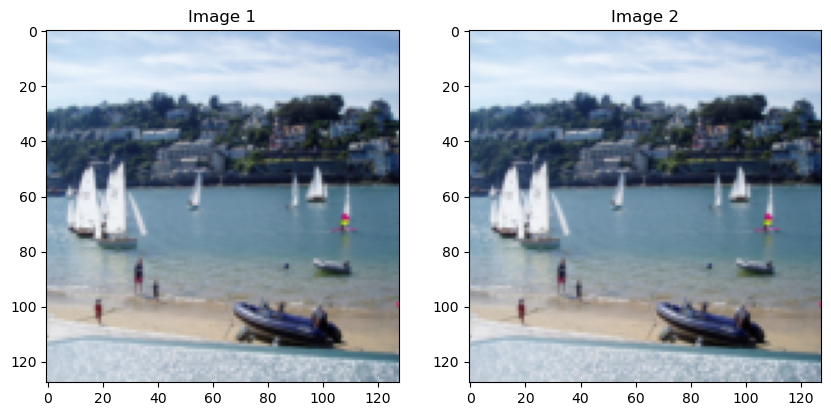

In [38]:
input_encoder_style = training_data_list[38]['image']

## plot reference style
plot_both(input_encoder_style.permute(1,2,0).numpy(),input_encoder_style.permute(1,2,0).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])


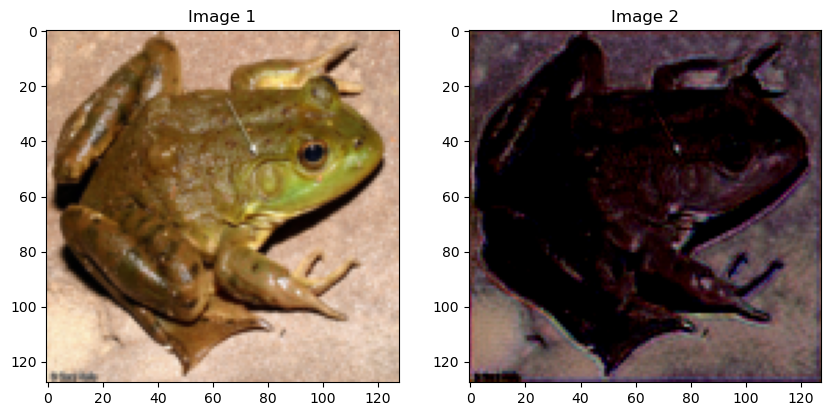

In [39]:
## style is the image itself
entry = training_data_list[32]
input_unet = entry['grayscale_image']
input_encoder = entry['image']
print(input_encoder.shape)
output = model(input_unet.unsqueeze(0).to(device), style_encoder(input_encoder.unsqueeze(0).to(device)))
output = output.detach().cpu().squeeze(0)
plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


#### Changed style

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])


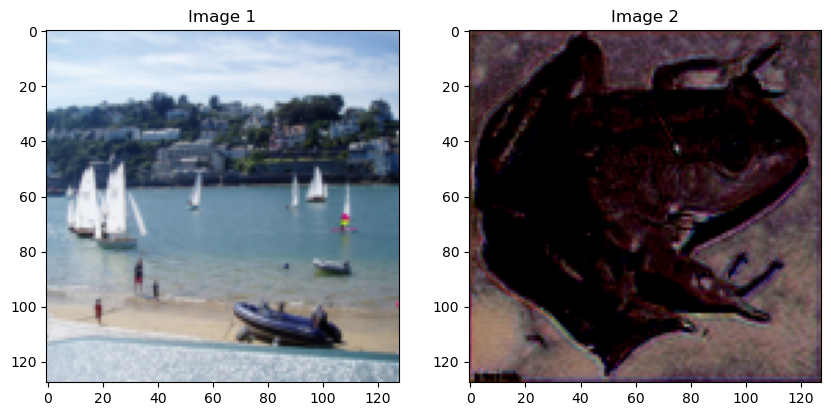

In [40]:
entry = training_data_list[32]
input_unet = entry['grayscale_image']
input_encoder = input_encoder_style
print(input_encoder.shape)
output = model(input_unet.unsqueeze(0).to(device), style_encoder(input_encoder.unsqueeze(0).to(device)))
output = output.detach().cpu().squeeze(0)
plot_both(input_encoder.permute(1,2,0).numpy(),output.permute(1,2,0).numpy())


In [25]:
reference_style = training_data_list[39]['image']
plot_both(reference_style.permute(1,2,0).numpy(),reference_style.permute(1,2,0).numpy())


NameError: name 'training_data_list' is not defined

In [ ]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, epochs=10, lr=0.0001, loss_fn=nn.MSELoss(), optimizer=torch.optim.Adam, verbose=True, save_path= 'experiment_results/LAB_100', save_name_prefix='/1000_training_')

In [ ]:
visualize(list(train_data)[32],model,lab=False)

### Colorization from LAB color space. 

Input is a HxW grayscale image (the l channel).
Output is 2xHxW representing the ab channels.

No std and mean normalization is used.

In [ ]:
TRAIN_SIZE = 600
VAL_SIZE = 150
BATCH_SIZE = 16

train_data, validation_data = dataset.prepare_dataset(train_size=TRAIN_SIZE, test_size=VAL_SIZE, batch_size=BATCH_SIZE,colorspace='LAB')
train_loader, validation_loader = dataset.prepare_dataloader(train_data, validation_data, batch_size=BATCH_SIZE)


'''
Since the model is trained against 3XHxW RGB images I expect the order of the channels in the ouput to be the same
'''

In [ ]:
model = UNet(in_C=1, out_C=2)

In [ ]:
model.train_model(train_loader=train_loader, val_loader=validation_loader, 
                  epochs=55, 
                  lr=0.0001, 
                  loss_fn=nn.MSELoss(), 
                  optimizer=torch.optim.Adam, 
                  verbose=True, 
                  save_path= 'experiment_results/LAB_55ep_600', 
                  save_name_prefix='/1000_training_',
                  colorspace='LAB')

In [ ]:

visualize(list(train_data)[32],model,lab=True)

In [ ]:

visualize(list(train_data)[19],model,lab=True)

In [ ]:

visualize(list(train_data)[42],model,lab=True)

In [ ]:

visualize(list(train_data)[43],model,lab=True)

In [ ]:
## must have length 8!
images_to_visualize_indexes = [3,12,5,17,11,3,28,29]

visualization_images = get_visualization_images(images_to_visualize_indexes)
outputs = get_batch_outputs(visualization_images)
plot_grid(visualization_images, outputs)